# COMP3222/6246 Machine Learning Technologies (2023/24)
## Lab 4 - Introduction to Tensorflow

This lab is an introduction to the Tensorflow library, a powerful tool to run machine learning algorithms in Python. The Tensorflow library is the backbone of the exercises you will find in lab 5 and lab 6. Its advantages include flexibility, parallel execution, and being a general framework for computation. On top of that, it is a good entry to put in your CV!

## 1. Installation

First of all, we need to import the library in Python. Some Python distributions have it included already, if yours does not, you can sidestep the issue and use [Google's Collaboratory environment](https://colab.research.google.com/). 

Still, it can be a good exercise to try and install it on your local machine. 

Note: If you created a virtual environment using conda, you need to activate it first. It is a good practice to work with virtual environments. See Lab0 - Setting up your environment for details on doing this. 

In Unix system's you can simply install it by:

```
pip3 install tensorflow
```

This will install Tensoflow 2, which will be used throughout this module. 

After the installation, run this short test to make sure everything is working:

In [1]:
import tensorflow as tf
tf.__version__

'2.14.0'

## 2. Tensors and Operations
TensorFlow's operations are carried out using tensors. A tensor is a multidimensional array and is very similar to a numpy array. It can also hold scaalr values. It is important to understand how to create and manipulate them when working with custom cost functions, custom layers and so on.  

In [2]:
# creating a matrix using tensors
A = tf.constant([[1,2,3],[4,5,6]])
print(A)

# creating a scalar using tensors
B = tf.constant(42)
print(B)

tf.Tensor(
[[1 2 3]
 [4 5 6]], shape=(2, 3), dtype=int32)
tf.Tensor(42, shape=(), dtype=int32)


You can use `tf.variable` to create tensors that may need to change and update over time. E.g. weights in a neural network.

In [6]:
x = tf.Variable(3.0, name="x")
y = tf.Variable(2.0, name="y")
z = tf.Variable(1.0, name="z")
g = x*y*z+x*x+z

print(g.numpy())

16.0


The code above creates a simple function of three variables.

*Exercise 1.1.* Modify the code above to compute the value of $f(x,y,z) = x^3 + y^2 + yz + 3$ with $x=-2$, $y=5$ and $z=1.2$
Hint: you can use `assign()` method to modify the values of `tf.variable`. E.g. to change the value of $x$, use `x.assign()`. 

In [7]:
x.assign(-2)
y.assign(5)
z.assign(1.2)

f = x*x*x + y*y + y*z + 3
print(f.numpy())

26.0


## 3. Linear Regression
In Tensorflow, we can easily define operations on whole arrays, matrices and multi-dimensional matrices (aka tensors). In this section, we look at a straightforward implementation of the vanilla linear regression algorithm.

We will use California housing dataset for this section. Details of the dataset can be found at: https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset. You can load the dataset using Scikit-Learn's `fetch_california_housing()` function.

**Recap of Linear Regression:**
Linear regression model prediction can be written concisely in vector form as $\mathbf{y} = \mathbf{w^Tx}$, where $\mathbf{y}$ is the matrix of target predictions, $\mathbf{x}$ is the matrix of features and and $\mathbf{w}$ is the matrix of weights.

The mean squared error (MSE) for the linear regression model is $MSE = 1/m \times \sum_{i=1}^{m} (w^Tx^{(i)} - y^{(i)})^2$

The closed form solution of the weights $\mathbf{w}$ that minimizes the MSE is called the Normal Equation: $\mathbf{w} = ((\mathbf{X}^T\mathbf{X})^{-1} \mathbf{X}^T) \mathbf{y}$. 

In the above equation, $(\mathbf{X}^T\mathbf{X})^{-1} \mathbf{X}^T)$ is also called the pseudo-inverse of $\mathbf{X}$.

The below snippet of code implements the linear regression formulation discussed above:

In [9]:
import numpy as np 
from sklearn.datasets import fetch_california_housing

# load the dataset
housing = fetch_california_housing()
m, n = housing.data.shape
housing_features = np.c_[np.ones((m,1)), housing.data]

# define the pseudo-inverse equation in tensorflow
X = tf.constant(housing_features, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
Xt = tf.transpose(X)

w = tf.matmul(tf.matmul(tf.linalg.inv(tf.matmul(Xt, X)), Xt), y)

weights = w.numpy()

print(weights)

# # run the computation
# with tf.Session() as sess:
    

[[-3.6896515e+01]
 [ 4.3682209e-01]
 [ 9.4436919e-03]
 [-1.0742678e-01]
 [ 6.4522374e-01]
 [-3.9421757e-06]
 [-3.7879660e-03]
 [-4.2084768e-01]
 [-4.3402091e-01]]


*Exercise 2.1.* Running the above cell gives you an error. Can you figure out what the error is?
Hint: The pseudo-inverse equation in the code above is wrong. Fix the error. Refer to the **recap** above.

*Exercise 2.2.* Modify the code above to compute some estimates over the training set. Print the training RMSE.

In [10]:
#step-by-step hints

# calculate y_predicted (hint: tf.matmul(X,w))
y_pred = tf.matmul(X, w)


# calculate error (hint: y - y_pred)
error = y - y_pred


# calculate RMSE (hint: use tf.square, tf.reduce_mean and tf.sqrt)
rmse = tf.sqrt(tf.reduce_mean(tf.square(error)))
print(rmse.numpy())



0.7241085


## 3. Gradient descent
When the number of features and the dataset are large, computing the pseudo-inverse can become computationally expensive. A more efficient approach is gradient descent, which consists in starting from a randomly selected point and slowly creeping toward the solution. Not only this approach is quick, but it generalises well beyond linear methods. In fact, this is the backbone of the many non-linear neural networks and deep learning algorithms that define the current state-of-the-art.

Here is an example of how to implement gradient descent in Tensorflow. In this case, the gradients are computed *automagically* by automatic differentiation. This is a quite fascinating computational technique that saves us from computing first-order derivatives with pen and paper. Link to read more about autodiff - https://www.tensorflow.org/guide/autodiff

In [11]:
n_steps = 10000
learn_rate = 0.01

X = tf.constant(housing_features, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
w = tf.Variable(tf.random.uniform([n+1,1], -1.0, 1.0), name="w")
    
for step in range(n_steps):
    if step % 500 == 0:
        with tf.GradientTape() as tape:
            y_hat = tf.matmul(X, w, name="y_hat")
            error = y - y_hat
            mse = tf.reduce_mean(tf.square(error), name="mse")
            print("Step", step, "MSE =", mse.numpy())
            
        gradients = tape.gradient(mse, [w])
        w.assign(w - learn_rate * gradients[0])
        

    
w_best = w.numpy()

Step 0 MSE = 2197695.2
Step 500 MSE = 9692085000000000.0
Step 1000 MSE = 4.2843227e+25
Step 1500 MSE = inf
Step 2000 MSE = inf
Step 2500 MSE = inf
Step 3000 MSE = inf
Step 3500 MSE = inf
Step 4000 MSE = inf
Step 4500 MSE = nan
Step 5000 MSE = nan
Step 5500 MSE = nan
Step 6000 MSE = nan
Step 6500 MSE = nan
Step 7000 MSE = nan
Step 7500 MSE = nan
Step 8000 MSE = nan
Step 8500 MSE = nan
Step 9000 MSE = nan
Step 9500 MSE = nan


*Exercise 3.1.* Add comments to the code above. Do you understand the purpose of each line?

*Exercise 3.2.* Perform feature scaling on the dataset and run the gradient descent algorithm again. Do you see any difference in the result? What about the number of steps needed to converge to the optimum?

*Hint for feature scaling:* Before feeding the training set to your favourite ML algorithm, it is good practice to normalise the input features. This means scaling them so that their values fall more or less in the same range. The scikit library offers two different scaling methods: min-max scaling, and standard scaling.

`MinMaxScaler` in the Scikit-learn library transforms features by scaling each feature to a given range; see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler. 

`StandardScaler` in the Scikit-learn library transforms features to have zero mean and unit variance; see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html. 


The below code demonstrates the use of `MinMaxScaler`. 

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(housing_features)
scaled_housing_features = scaler.transform(housing_features)

n_steps = 10000
learn_rate = 0.01

scaled_X = tf.constant(scaled_housing_features, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
w = tf.Variable(tf.random.uniform([n+1,1], -1.0, 1.0), name="w")
    
for step in range(n_steps):
    if step % 500 == 0:
        print("Step", step, "MSE =", mse.numpy())
        with tf.GradientTape() as tape:
            y_hat = tf.matmul(scaled_X, w, name="y_hat")
            error = y - y_hat
            mse = tf.reduce_mean(tf.square(error), name="mse")
    
        gradients = tape.gradient(mse, [w])
        w.assign(w - learn_rate * gradients[0])
         
w_best = w.numpy()

Step 0 MSE = nan
Step 500 MSE = 7.396819
Step 1000 MSE = 7.228994
Step 1500 MSE = 7.065887
Step 2000 MSE = 6.907363
Step 2500 MSE = 6.753293
Step 3000 MSE = 6.603552
Step 3500 MSE = 6.458017
Step 4000 MSE = 6.31657
Step 4500 MSE = 6.1790953
Step 5000 MSE = 6.045481
Step 5500 MSE = 5.9156184
Step 6000 MSE = 5.789402
Step 6500 MSE = 5.666727
Step 7000 MSE = 5.5474963
Step 7500 MSE = 5.4316115
Step 8000 MSE = 5.318977
Step 8500 MSE = 5.209503
Step 9000 MSE = 5.1031
Step 9500 MSE = 4.9996805


Run the above code using `StandardScaler` and observe the difference.

*Exercise 3.3.* The gradient descent algorithm is really sensitive to the value of the learning rate. Try changing it by a few orders of magnitude in the above and run the algorithm again.

## 4. Regression MLPs

You can use Multilayer Perceptrons for regression tasks. If you are predicting a single value (e.g. price of a house given some features), you need one output neuron. You can also predict multiple values, in which case, the task is called multivariate regression and you would need one output neuron per output dimension. When building an MLP for regression, you may not choose to use activation functions so that they can output freely any range of values. Or you can choose to use certain activation functions to constrain the range of the output values.

Using `tf.keras`, which implements the Keras API with some extra TensorFlow-speific features, we will build an MLP to perform the Regression task. Specifically, we will use Sequential API, which enables a straightforward way to build a neural network in TensorFlow.

In [13]:
# To allow training and testing, we need to split the California housing data into training, validation and test sets
# We also use StandardScaler for feature scaling -- try other scaling methods on your own.

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

np.random.seed(42)
tf.random.set_seed(42)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))


Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 2.0218 - val_loss: 0.8834
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.7392 - val_loss: 0.6547
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6597 - val_loss: 0.6251
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6150 - val_loss: 0.5748
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5829 - val_loss: 0.5405
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5568 - val_loss: 0.5276
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5372 - val_loss: 0.5246
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5210 - val_loss: 0.4847
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5067 - val_loss: 0.4728
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4945 - val_loss: 0.4678

*Exercise 4.1.* Add comments to the code above. Do you understand the purpose of each line?
Hint: The code above uses Sequnetial API to build and train a Regression MLP. `tf.keras.models.Sequential` creates a neural network composed of single stack of layers connected sequentially. `tf.keras.layers.Dense` is used to create a Dense layer that manages its own weight matrix with connection weights between the neurons and their input. You can also add an activation function to the layer. 

Hint: In `model.compile` try changing the learning rate and run the model again.

Hint: The number of epochs are defined in `model.fit`. You can also pass a validation set that will be used to calculate validation accuracy. Notice that the training loss and validation loss are different. 

**Plotting Learning Curves:** `model.fit` return history object containing training paramters (`history.params`), list of epochs (`history.epoch`) and a dictionary containing loss and other metrics measured at the end of each epoch (`history.history`). You can use pandas DataFrame and `plot()` method to plot learning curves as below.

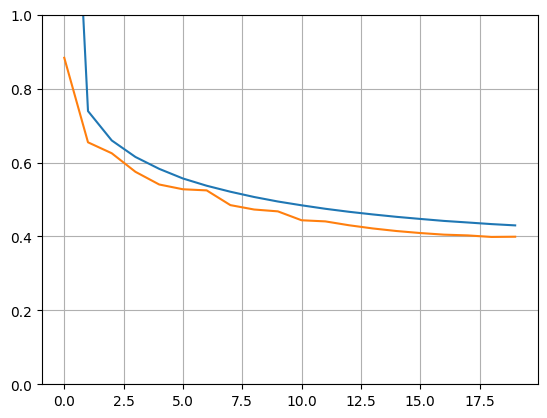

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Remember that you created a test set in the above code. Using the test set, do the following exercises. 

*Exercise 4.2.* Calculate the MSE on the test set. 
Hint: Use `model.evaluate`. Link for more information: https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate.

*Exercise 4.3.* Using a datapoint from the test set, predict the output. Hint: Use `model.predict`. Link for more information: https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict.

In [15]:
#Step-by-step hints

#Calculate MSE on the test set using 'model.evaluate(X_test,Y_test)''
mse_test = model.evaluate(X_test, y_test)


#Pick a datapoint from the test set --> X_new = X_test[:1]
X_new = X_test[:1]


#Calculate y_pred using 'model.predict(X_new)'
y_pred = model.predict(X_new)


#print y_pred
print(y_pred)

1/1 [==============================] - 0s 78ms/step
[[0.558897]]


## This week's Summary
We have looked at some basic functionality of Tensorflow. TensorFlow offers a wide range of features. The most important is `tf.keras`, which you will be using frequently in this module to carry out building and training networks. However, there are other key features for loading and preprocessing data, image processing and signal processing. 

In the coming weeks, we will explore more funtionality of Tensorflow while building and training more complex networks. 